# RNN Moneymaker

In [1]:
import csv
import re
import torch
import time
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from datetime import datetime

import torch.optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [2]:
root_path = 'scrape/data/'

In [3]:
seq = []
y = []
name_and_date = []
window_size = 122

all_files = os.listdir(root_path)

for i, filename in enumerate(all_files):
    
    # Only load a 1/N of all stocks
    if i % 50 == 0:
    
        len_stocks = len(all_files)
        print("Loading stock {}/{} ({})".format(i + 1, len_stocks, filename), end='\r')
        
        with open(root_path + filename) as f:
            if not filename.startswith('.'):
                data = json.load(f)

                temp1 = [] # for prices
                temp2 = [] # for name and date
                
                for k, v in data.items():
                    temp1.append(torch.tensor([ float(i[1]) for i in v.items() if i[0] != "5. volume" ]).unsqueeze(0))
                    temp2.append(k)
                
                # reverse so that data is increasing in time
                temp1.reverse()
                temp2.reverse()
                                
                prices = torch.cat(temp1, 0)
                
                for i in range(len(prices) - window_size - 1):
                    seq.append(prices[i:i+window_size].unsqueeze(0))
                    y.append(prices[i+window_size][3].item()) # predict the closing price
                    name_and_date.append([filename.split('.')[0], temp2[i + window_size + 1]])
                    
X = torch.cat(seq, 0)
y = torch.tensor(y).unsqueeze(1) # from (N,) to (N,1)

print(X.shape)
print(y.shape)

torch.Size([178750, 122, 4])E.txt))
torch.Size([178750, 1])


In [ ]:
torch.save(X, 'assets/X.pt')
torch.save(y, 'assets/y.pt')

In [ ]:
X = torch.load('assets/X.pt')
y = torch.load('assets/y.pt')

### Normalize the input across each window-sized sequence

torch.Size([178750, 122, 4])
torch.Size([178750, 1])


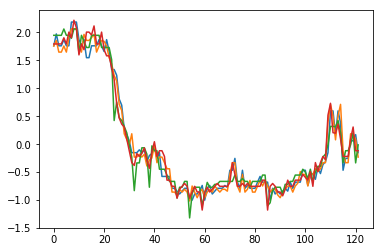

In [4]:
X_mean = torch.mean(X, dim=1).unsqueeze(1)
X_std = torch.std(X, dim=1).unsqueeze(1)

X = (X - X_mean) / X_std
y = (y - X_mean[:,:,3]) / X_std[:,:,3]

print(X.shape)
print(y.shape)
plt.plot(X[0])

### Remove all inputs and corresponding outputs that containt NaN's

In [5]:
print("old:")
print(X.shape)
print(y.shape)

a = torch.sum(torch.sum(X == X, dim=1), dim=1) != 0
b = (y == y) != 0

c = a if torch.sum(a) < torch.sum(b) else b

X = X[c]
y = y[c] # To make y (N, 1) from (N,)

print("new:")
print(X.shape)
print(y.shape)

old:
torch.Size([178750, 122, 4])
torch.Size([178750, 1])
new:
torch.Size([178730, 122, 4])
torch.Size([178730, 1])


### Split data into training and validation sets

In [6]:
N, S, D = X.shape
perm = np.random.permutation(N)
num_train = int(0.99*N)

train_selector = perm[0:num_train]
val_selector = perm[num_train:]

X_train = X[train_selector]
y_train = y[train_selector]
X_val = X[val_selector]
y_val = y[val_selector]

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_val shape: ", X_val.shape)
print("y_val shape: ", y_val.shape)

X_train shape:  torch.Size([176942, 122, 4])
y_train shape:  torch.Size([176942, 1])
X_val shape:  torch.Size([1788, 122, 4])
y_val shape:  torch.Size([1788, 1])


### Training a RNN

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [8]:
batch_size = 32
dataset = Dataset(X_train, y_train)
loader = DataLoader(dataset, batch_size)

In [9]:
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RNNClassifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.drop = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x, h=None):
        if type(h) == type(None):
            out, hn = self.rnn(x)
        else:
            out, hn = self.rnn(x, h.detach())
        out = self.drop(out)
        out = self.fc(out[:, -1, :])
        return out

In [10]:
input_dim = 4
hidden_dim = 20
output_dim = 1

In [11]:
model = RNNClassifier(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [12]:
train_accs = []
val_accs = []
train_losses = []
val_losses = []
epoch = 0

In [13]:
t0 = time.time()
num_epochs = 3
for ep in range(num_epochs):
    tstart = time.time()
    for i, data in enumerate(loader):
        print(i, end='\r')
        optimizer.zero_grad()
        outputs = model(data[0])
        loss = criterion(outputs, data[1])
        loss.backward()
        optimizer.step()
    
        if i % 100==0:
            train_losses.append(loss.item())
            pXval = model(X_val)
            vloss = criterion(pXval, y_val)
            val_losses.append(vloss.item())
            print("training loss: {:<3.3f} \t val loss: {:<3.3f}".format(loss, vloss))
    
    ptrain = model(X_train)
    tloss = criterion(ptrain, y_train)
    train_losses.append(tloss.item())
    
    pXval = model(X_val)
    vloss = criterion(pXval, y_val)
    val_losses.append(vloss.item())
    epoch += 1    
    tend = time.time()
    print('epoch: {:<3d} \t time: {:<3.2f} \t training loss: {:<3.3f} \t val loss: {:<3.3f}'.format(epoch, 
            tend - tstart, tloss.item(), vloss.item()))
time_total = time.time() - t0
print('Total time: {:4.3f}, average time per epoch: {:4.3f}'.format(time_total, time_total / num_epochs))

training loss: 2.308 	 val loss: 2.246
training loss: 0.162 	 val loss: 0.592
training loss: 0.355 	 val loss: 0.460
training loss: 0.247 	 val loss: 0.408
training loss: 0.336 	 val loss: 0.361
training loss: 0.255 	 val loss: 0.364
training loss: 0.236 	 val loss: 0.346
training loss: 0.372 	 val loss: 0.311
training loss: 0.121 	 val loss: 0.290
training loss: 0.197 	 val loss: 0.305
training loss: 0.209 	 val loss: 0.296
training loss: 0.445 	 val loss: 0.280
training loss: 0.235 	 val loss: 0.288
training loss: 0.426 	 val loss: 0.275
training loss: 0.213 	 val loss: 0.293
training loss: 0.596 	 val loss: 0.288
training loss: 0.207 	 val loss: 0.261
training loss: 0.100 	 val loss: 0.274
training loss: 0.161 	 val loss: 0.251
training loss: 0.393 	 val loss: 0.249
training loss: 0.223 	 val loss: 0.267
training loss: 0.374 	 val loss: 0.238
training loss: 0.594 	 val loss: 0.255
training loss: 0.215 	 val loss: 0.245
training loss: 0.229 	 val loss: 0.248
training loss: 0.173 	 va

In [ ]:
torch.save(model, 'assets/model.pt')

### Model evaluation

In [ ]:
model = torch.load('assets/model.pt')

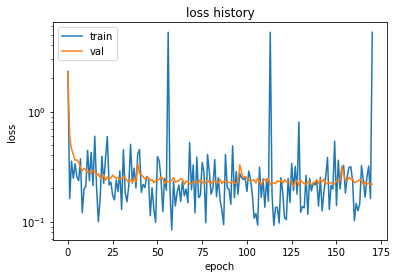

In [14]:
t_losses = [i for i in train_losses if i < 4000]
plt.plot(t_losses)
plt.plot(val_losses)
plt.title('loss history')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.yscale('log')
plt.legend(['train', 'val'])

In [15]:
model.eval()

RNNClassifier(
  (rnn): LSTM(4, 20, batch_first=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [16]:
pred = model(X_val)
print(criterion(pred, y_val))

tensor(0.1290, grad_fn=<MseLossBackward>)


### Model predictions compared to standard deviations

Text(0.5,1,'std difference')

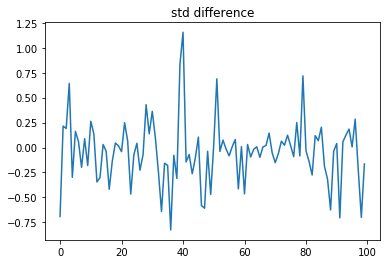

In [136]:
pred = model(X_val)

plt.plot((pred - y_val).detach()[1000:1100])
plt.title('std difference')

### Model predictions compared to actual price

Text(0.5,1,'absolute price difference')

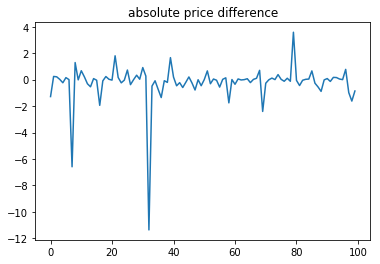

In [139]:
pred_abs = pred * X_std[val_selector][:,:,3] + X_mean[val_selector][:,:,3]
y_val_abs = y_val * X_std[val_selector][:,:,3] + X_mean[val_selector][:,:,3]

plt.plot((pred_abs - y_val_abs).detach()[1000:1100])
plt.title('absolute price difference')

### Testing and visualizing random stock in test data

In [138]:
val_names_and_dates = np.array(name_and_date)[val_selector]

stock = "AUTO";
stock_selector = torch.tensor(val_names_and_dates[:,0] == (stock + ".txt"))

s_pred_abs = pred_abs[stock_selector]
s_y_val_abs = y_val_abs[stock_selector]

stock_dates = val_names_and_dates[stock_selector][:,1]

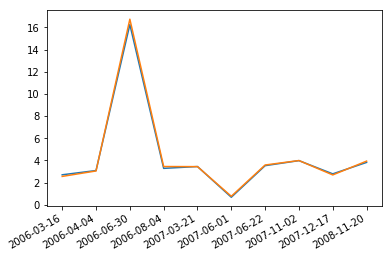

In [143]:
stock_dates.sort()
fig, ax = plt.subplots()
ax.plot(stock_dates[10:20], s_pred_abs.detach()[10:20])
ax.plot(stock_dates[10:20], s_y_val_abs.detach()[10:20])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()

### Testing random unseen stock (skipped over in the data loading stage)

tensor(0.1389, grad_fn=<MseLossBackward>)


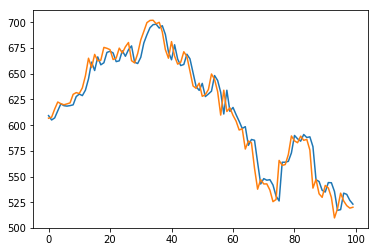

In [135]:
seq = []
test_y = []
test_name_and_date = []
window_size = 122

with open(root_path + "AAPL.txt") as f:
    data = json.load(f)

    temp1 = [] # for prices
    temp2 = [] # for name and date

    for k, v in data.items():
        temp1.append(torch.tensor([ float(i[1]) for i in v.items() if i[0] != "5. volume" ]).unsqueeze(0))
        temp2.append(k)

    # reverse so that data is increasing in time
    temp1.reverse()
    temp2.reverse()

    prices = torch.cat(temp1, 0)

    for i in range(len(prices) - window_size - 1):
        seq.append(prices[i:i+window_size].unsqueeze(0))
        test_y.append(prices[i+window_size][3].item()) # predict the closing price
        test_name_and_date.append(['AAPL', temp2[i + window_size + 1]])
        
test_X = torch.cat(seq, 0)
test_y = torch.tensor(test_y).unsqueeze(1) # from (N,) to (N,1)

test_X_mean = torch.mean(test_X, dim=1).unsqueeze(1)
test_X_std = torch.std(test_X, dim=1).unsqueeze(1)

test_X = (test_X - test_X_mean) / test_X_std
test_y = (test_y - test_X_mean[:,:,3]) / test_X_std[:,:,3]

test_pred = model(test_X)
print(criterion(test_pred, test_y))

test_pred = test_pred * test_X_std[:,:,3] + test_X_mean[:,:,3]
test_y = test_y * test_X_std[:,:,3] + test_X_mean[:,:,3]

plt.plot(test_pred.detach()[3000:3100])
plt.plot(test_y[3000:3100])

In [122]:
dates = [i[1] for i in test_name_and_date]
print(dates)
temp_pred = [ i.data[0] for i in test_pred.detach().numpy() ]
temp_y = [ i.data[0] for i in test_y.detach().numpy() ]

['2000-08-29', '2000-08-30', '2000-08-31', '2000-09-01', '2000-09-05', '2000-09-06', '2000-09-07', '2000-09-08', '2000-09-11', '2000-09-12', '2000-09-13', '2000-09-14', '2000-09-15', '2000-09-18', '2000-09-19', '2000-09-20', '2000-09-21', '2000-09-22', '2000-09-25', '2000-09-26', '2000-09-27', '2000-09-28', '2000-09-29', '2000-10-02', '2000-10-03', '2000-10-04', '2000-10-05', '2000-10-06', '2000-10-09', '2000-10-10', '2000-10-11', '2000-10-12', '2000-10-13', '2000-10-16', '2000-10-17', '2000-10-18', '2000-10-19', '2000-10-20', '2000-10-23', '2000-10-24', '2000-10-25', '2000-10-26', '2000-10-27', '2000-10-30', '2000-10-31', '2000-11-01', '2000-11-02', '2000-11-03', '2000-11-06', '2000-11-07', '2000-11-08', '2000-11-09', '2000-11-10', '2000-11-13', '2000-11-14', '2000-11-15', '2000-11-16', '2000-11-17', '2000-11-20', '2000-11-21', '2000-11-22', '2000-11-24', '2000-11-27', '2000-11-28', '2000-11-29', '2000-11-30', '2000-12-01', '2000-12-04', '2000-12-05', '2000-12-06', '2000-12-07', '2000

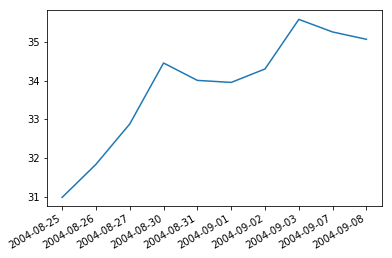

In [131]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots()
ax.plot(dates[1000:1010], temp_pred[1000:1010])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()

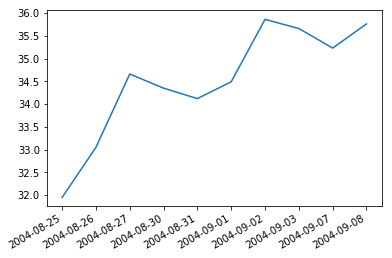

In [133]:
fig, ax = plt.subplots()
ax.plot(dates[1000:1010], temp_y[1000:1010])
fig.autofmt_xdate()
start, end = ax.get_xlim()
plt.show()